# Optimized dataset of logged interactions

When incrementally training a bandit agent, one approach is to implement on-policy learning, where the agent (i) makes predictions based on existing item reward estimates and uncertainty, and (ii) refines its policy by using only user’s (and system’s) feedback to its previous predictions.

One approach is to trigger an update or retraining after some number of `<context, prediction, reward>` tuples have been logged, where the total number of these tuples makes up an incremental training data slice. 

To minimize bottlenecks in our training data input pipeline, we can preprocess the training examples, batch them, and store them in a TF Record (which allows for fast sequential reads)

<img src="imgs/online_learning_ra.png" 
     align="center" 
     width="850"
     height="850"/>

### Notebook config

In [2]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import sys
import json
import time
import functools
import collections
import pickle as pkl
from pprint import pprint
from typing import Callable, Dict, List, Optional, TypeVar, Any

# logging
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage, bigquery

# tensorflow
import tensorflow as tf

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.metrics import tf_metrics
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.trajectories import trajectory
from tf_agents import trajectories

from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import policy_saver
from tf_agents.metrics import export_utils
from tf_agents.eval import metric_utils
from tf_agents.utils import common

# this repo
sys.path.append("..")
from src.utils import train_utils
from src.data import data_utils, data_config
from src.trainer import train_batched_ds
from src.data_preprocessor import preprocess_utils

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# GPU
from numba import cuda 
import gc

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

## Data prep

### get data path

In [10]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v4/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v5/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


In [11]:
TFRECORD_NAME = "mv_b128_g12_a16_v6"
TFR_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}/{TFRECORD_NAME}"
!gsutil ls $TFR_DATA_PATH

gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/mv_b128_g12_a16_v6.tfrecord
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/tmp_bq.json


**The file name tells us the `batch_size`, `global_dim`, and `per_arm_dim` used to create dataset**

> `f"mv_b{batch_size}_g{global_emb_size}_a{mv_emb_size}_{pipeline_version}"`

where `mv_b128_g12_a16_v6`
* `batch_size`     : 128
* `global_emb_size`: 12
* `mv_emb_size`    : 16

In [12]:
TFRECORD_FILE = (
    f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}/{TFRECORD_NAME}/{TFRECORD_NAME}.tfrecord"
)

GLOBAL_EMBEDDING_SIZE = 12
MV_EMBEDDING_SIZE = 16

# sanity check
N_GLOBAL_FEATURES = len(data_utils.USER_FEATURE_NAMES)     # 6
N_ARM_FEATURES    = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
GLOBAL_DIM        = GLOBAL_EMBEDDING_SIZE * N_GLOBAL_FEATURES
PER_ARM_DIM       = MV_EMBEDDING_SIZE * N_ARM_FEATURES

print(f"TF Record : {TFRECORD_FILE}")
print(f"GLOBAL_DIM : {GLOBAL_DIM}")
print(f"PER_ARM_DIM : {PER_ARM_DIM}")

TF Record : gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/mv_b128_g12_a16_v6.tfrecord
GLOBAL_DIM : 72
PER_ARM_DIM : 64


### get vocabs

In [36]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



#### tmp - debugging dataset - START

In [14]:
x = tf.constant([5, 1, 2, 4])
tf.reduce_max(x, axis=0)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [19]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1
NUM_ACTIONS     = 2

In [10]:
_raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE])
_parsed_dataset = _raw_dataset.map(preprocess_utils._parse_record)

In [15]:
NUM_BATCHES = len(list(_parsed_dataset))
NUM_SAMPLES = NUM_BATCHES * BATCH_SIZE

print(f"NUM_BATCHES : {NUM_BATCHES}")
print(f"NUM_SAMPLES : {NUM_SAMPLES}")

7766

In [93]:
def _get_rewards(observation):
    return observation.reward

def optimal_reward(observation):
    """
    Outputs the maximum expected reward for every element in the batch
    """
    return tf.reduce_max(_get_rewards(observation), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

In [21]:
for x in _parsed_dataset.take(1):
    # print(x)
    _parsed_trajectories = preprocess_utils.build_trajectory_from_tfrecord(x, BATCH_SIZE, NUM_ACTIONS)
    print(_parsed_trajectories)
    break

Trajectory(
{'action': <tf.Tensor: shape=(128, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
     

In [95]:
_parsed_trajectories.reward.shape

TensorShape([128, 1])

In [99]:
batched_reward = optimal_reward(_parsed_trajectories)
total_reward = tf.reduce_sum(batched_reward)

print(f"batched_reward : {batched_reward}")
print(f"total_reward : {total_reward}")

(128, 1)
batched_reward : [5. 4. 2. 2. 3. 3. 2. 4. 4. 4. 4. 1. 2. 4. 4. 4. 3. 2. 2. 3. 3. 4. 5. 3.
 4. 3. 3. 5. 4. 1. 2. 5. 3. 5. 4. 3. 4. 4. 3. 3. 4. 4. 3. 3. 2. 2. 2. 5.
 3. 3. 5. 4. 5. 3. 4. 3. 3. 5. 4. 2. 3. 2. 4. 3. 2. 5. 4. 4. 3. 3. 1. 2.
 4. 3. 3. 4. 3. 4. 2. 5. 4. 3. 4. 2. 4. 4. 5. 2. 4. 4. 2. 5. 1. 2. 5. 5.
 1. 4. 4. 1. 2. 4. 5. 2. 3. 4. 3. 2. 3. 3. 1. 3. 4. 4. 4. 4. 5. 3. 3. 4.
 3. 2. 3. 3. 5. 3. 4. 4.]
total_reward : 425.0


In [85]:
# GLOBAL_DIM = 40 
# PER_ARM_DIM = 50
# reward_param = list(np.random.randint(0, 10, [GLOBAL_DIM + PER_ARM_DIM]))
# global_obs = tf.constant(np.random.randint(1, 13, dtype=np.int32), shape=[20, 40])      # [20, 40]
# per_arm_obs = tf.constant(np.random.randint(1, 13, dtype=np.int32), shape=[20, 70, 50])
# num_actions = tf.shape(per_arm_obs)[1]
# tiled_global = tf.tile(
#     tf.expand_dims(global_obs, axis=1), [1, num_actions, 1] # [20, 70, 40]
# )
# concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1) # [20, 70, 90]
# rewards = tf.linalg.matvec(concatenated, reward_param)
# rewards

<tf.Tensor: shape=(20, 70), dtype=int32, numpy=
array([[4442, 4442, 4442, ..., 4442, 4442, 4442],
       [4442, 4442, 4442, ..., 4442, 4442, 4442],
       [4442, 4442, 4442, ..., 4442, 4442, 4442],
       ...,
       [4442, 4442, 4442, ..., 4442, 4442, 4442],
       [4442, 4442, 4442, ..., 4442, 4442, 4442],
       [4442, 4442, 4442, ..., 4442, 4442, 4442]], dtype=int32)>

#### tmp - debugging dataset - END

## Agent config

In [15]:
BATCH_SIZE      = 128
NUM_ACTIONS     = 2

EVAL_BATCH_SIZE = 1

AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'
AGENT_ALPHA     = 0.1
EPSILON         = 0.01
LR              = 0.05
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

GLOBAL_LAYERS   = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS      = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])
COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

NETWORK_TYPE = "commontower" # 'commontower' | 'dotproduct'
if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1] 
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2
GLOBAL_DIM      : 72
PER_ARM_DIM     : 64


In [16]:
HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "agent_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_emb_size": GLOBAL_EMBEDDING_SIZE,
    "arm_emb_size": MV_EMBEDDING_SIZE,
    "global_dim": GLOBAL_DIM,
    "per_arm_dim": PER_ARM_DIM,
    "agent_alpha": AGENT_ALPHA,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "encoding_dim": ENCODING_DIM,
    "eps_phase_steps": EPS_PHASE_STEPS,
    "summarize_grads_and_vars" : False,
    "debug_summaries": True,
}
pprint(HPARAMS)

{'agent_alpha': 0.1,
 'agent_type': 'epsGreedy',
 'arm_emb_size': 16,
 'batch_size': 128,
 'common_layers': [34, 8],
 'debug_summaries': True,
 'encoding_dim': 1,
 'eps_phase_steps': 1000,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_dim': 72,
 'global_emb_size': 12,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_dim': 64,
 'per_arm_layers': [64, 32, 16],
 'summarize_grads_and_vars': False}


## Define Vertex Experiment

In [17]:
EXPERIMENT_NAME   = f'2x-optimized-train-eval-v4'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 2x-optimized-train-eval-v4
RUN_NAME          : run-20240618-193056

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/logs
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts


## Train config

> config training and evaluation loops

In [18]:
NUM_EPOCHS       = 2
LOG_INTERVAL     = 10
CHKPT_INTERVAL   = 1000
TOTAL_TRAIN_TAKE = 50
TOTAL_TRAIN_SKIP = 0

PROFILER   = False
CACHE_DATA = False

### training loop

In [19]:
#start the timer and training
start_time = time.time()

# tf.profiler.experimental.start(LOG_DIR)
train_loss, agent = train_batched_ds.train(
    hparams=HPARAMS,
    experiment_name=EXPERIMENT_NAME,
    experiment_run=RUN_NAME,
    num_epochs = NUM_EPOCHS,
    log_dir=LOG_DIR,
    artifacts_dir=ARTIFACTS_DIR,
    chkpoint_dir=CHECKPT_DIR,
    tfrecord_file=TFRECORD_FILE,
    log_interval=LOG_INTERVAL,
    # chkpt_interval=CHKPT_INTERVAL,
    use_gpu = True,
    # profiler = PROFILER,
    total_take = TOTAL_TRAIN_TAKE,
    total_skip = TOTAL_TRAIN_SKIP,
    cache_train_data = CACHE_DATA,
)
# tf.profiler.experimental.stop()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

hparams dict:
{'agent_alpha': 0.1,
 'agent_type': 'epsGreedy',
 'arm_emb_size': 16,
 'batch_size': 128,
 'common_layers': [34, 8],
 'debug_summaries': True,
 'encoding_dim': 1,
 'eps_phase_steps': 1000,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_dim': 72,
 'global_emb_size': 12,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_dim': 64,
 'per_arm_layers': [64, 32, 16],
 'summarize_grads_and_vars': False}
GLOBAL_BATCH_SIZE     : 128
distribution_strategy : <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f973a4d2ef0>
NUM_REPLICAS          : 1
set checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/chkpoint
set saver: <tf_agents.policies.policy_saver.PolicySaver object at 0x7f97323bfd60>
setting dataset total_take: 50
starting train loop...
epoch: 1
step = 0: loss = 13.579999923706055
step = 10: loss = 12.140000343322754
step = 20: loss = 10.39000034

In [ ]:
# tf.profiler.experimental.stop()

In [20]:
train_loss[-1]

1.0382987

In [21]:
type(train_loss[0].tolist())

float

## Evaluate Train job

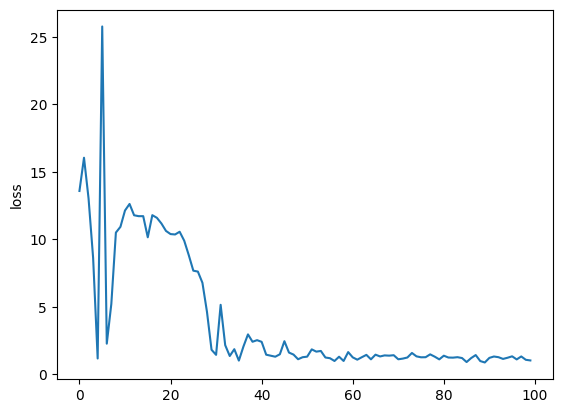

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.ylabel('loss')
plt.show()

#### Load TensorBoard

> on the right-hand side, find `PROFILE` in the drop down:

<img src="imgs/getting_profiler.png" 
     align="center" 
     width="850"
     height="850"/>
     
<!-- tf_vertex_agents/imgs/getting_profiler.png -->

In [23]:
# %load_ext tensorboard
%reload_ext tensorboard

In [24]:
%tensorboard --logdir=$LOG_DIR

In [25]:
! gsutil ls $ARTIFACTS_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/2x-optimized-train-eval-v4/run-20240618-193056/artifacts/variables/


# Evaluate policy

> Evaluate the agent's policy once after training

## Get eval dataset

In [26]:
def _get_rewards(observation):
    return observation.target_movie_rating # reward

def optimal_reward(observation):
    """
    Outputs the maximum expected reward for every element in the batch
    """
    return tf.reduce_max(_get_rewards(observation), axis=1)

In [27]:
SPLIT = "val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(data_utils._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])
    
NUM_EVAL_SAMPLES = len(list(eval_ds))
print(f"NUM_EVAL_SAMPLES : {NUM_EVAL_SAMPLES}")

NUM_EVAL_SAMPLES : 99417


In [28]:
type(NUM_EVAL_SAMPLES)

int

In [29]:
NUM_EVAL_STEPS  = 10_000

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

In [30]:
val_rewards = []

for x in eval_ds:
    # print(x)
    # break
    val_rewards.append(x['target_movie_rating'][0].numpy())
    
total_val_reward = tf.reduce_sum(val_rewards)
print(f"total_val_reward : {total_val_reward}")

total_val_reward : 35886.0


In [31]:
type(total_val_reward.numpy().tolist())

float

In [32]:
total_val_reward.numpy().tolist()

35886.0

### load trained policy

In [33]:
trained_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    ARTIFACTS_DIR, load_specs_from_pbtxt=True
)
trained_policy

In [34]:
from src.trainer import eval_perarm

In [37]:
# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

# post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = eval_perarm._run_bandit_eval(
    policy = trained_policy,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = HPARAMS['per_arm_dim'],
    global_dim = HPARAMS['global_dim'],
    vocab_dict = vocab_dict,
    num_oov_buckets = 1,
    global_emb_size = HPARAMS['global_emb_size'],
    mv_emb_size = HPARAMS['arm_emb_size'],
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating trained Agent...
post-train val_loss     : 1.2969787120819092
post-train eval runtime : 9


In [38]:
val_loss.numpy()

1.2969787

In [41]:
predicted_rewards = preds
# predicted_rewards

In [42]:
actual_rewards = tr_rewards
# actual_rewards

In [43]:
total_actual_rewards = tf.reduce_sum(actual_rewards).numpy()
total_predicted_rewards = tf.reduce_sum(predicted_rewards).numpy()
reward_gap = total_val_reward - total_predicted_rewards
reward_gap_percent = round((total_predicted_rewards / total_actual_rewards) * 100.0, 2)

print(f"total_val_reward        : {total_val_reward}")
print(f"total_actual_rewards    : {total_actual_rewards}")
print(f"total_predicted_rewards : {total_predicted_rewards}")
print(f"reward_gap              : {reward_gap}")
print(f"reward_gap_percent      : {reward_gap_percent}%")

total_val_reward        : 35886.0
total_actual_rewards    : 35886.0
total_predicted_rewards : 34683.91796875
reward_gap              : 1202.08203125
reward_gap_percent      : 96.65%


# Notes

### Train dataset

In [50]:
TFRECORD_FILE

'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/mv_b128_g12_a16_v6.tfrecord'

In [41]:
_raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE])
_parsed_dataset = _raw_dataset.map(preprocess_utils._parse_record)
_parsed_dataset

<_MapDataset element_spec={'action': TensorSpec(shape=(), dtype=tf.string, name=None), 'chosen_arm_features': TensorSpec(shape=(), dtype=tf.string, name=None), 'discount': TensorSpec(shape=(), dtype=tf.string, name=None), 'next_step_type': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': TensorSpec(shape=(), dtype=tf.string, name=None), 'reward': TensorSpec(shape=(), dtype=tf.string, name=None), 'step_type': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [42]:
total_ds_size = len(list(_parsed_dataset))

print(f"total_ds_size : {total_ds_size}")

total_ds_size : 7766


In [49]:
total_take=10

test_take_ds = _parsed_dataset.take(count=total_take)

count = 0
for x in test_take_ds:
    _parsed_trajectories = preprocess_utils.build_trajectory_from_tfrecord(
        x, HPARAMS['batch_size'], HPARAMS['num_actions']
    )
    count+=1
    
# _parsed_trajectories
count

10

## Val dataset

In [43]:
val_dataset

<_ParallelMapDataset element_spec={'target_movie_genres': TensorSpec(shape=(10,), dtype=tf.string, name=None), 'target_movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'target_movie_rating': TensorSpec(shape=(), dtype=tf.float32, name=None), 'target_movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'target_movie_year': TensorSpec(shape=(), dtype=tf.int64, name=None), 'target_rating_timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_age': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_gender': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_zip_code': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [44]:
total_val_ds_size = len(list(val_dataset))

print(f"total_val_ds_size : {total_val_ds_size}")

total_val_ds_size : 99417


**Finished**